## This script takes the predictions made from multiple models, compare them against the actual results, and determine how these models perform a statistical and operational context

### Outline of Notebook:

#### 4.1 Establish environment and creating threshold-evaluation functions
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>CSV_Reader()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>plot_histograms()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Threshold_Evaluation()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>generate_thresholds()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>create_prediction_cutoff_lists()</u><br>
#### 4.2 Determine optimal XGBoost perdiction cutoff thresholds
#### 4.3 Determine optimal Linear Learner perdiction cutoff thresholds
#### 4.4 Determine optimal Stacked perdiction cutoff thresholds
#### 4.5 Default Comparisons
#### 4.6  Identifying Optimal Predictions
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>select_best_performer()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>optimal_model_barchart()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Plot_Confusion_Matrix()</u><br>

## 4.1 Establish environment and creating threshold-evaluation functions

#### Importing Librries

In [1]:
#Data Manipulation Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import datetime

#Sagemaker/related Libraries
import sagemaker
from sagemaker import get_execution_role
import boto3
import io
from io import StringIO
from io import BytesIO
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
import os
smclient = boto3.Session().client('sagemaker')
s3 = boto3.client('s3')

#Data Visualization 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, precision_recall_curve, auc

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


#### Increase the dimensions of the displayed dataset

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

#### Defining variables to be used later

In [3]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = 'diabetes-directory'  # Replace with your S3 bucket name
input_prefix = 'processed_diabetes_data_3'  # Replace with the S3 prefix where your protobuf data is stored
test_with_predictions = "test_with_predictions.csv"
hist_figsize=(5, 3)
xgb = "xgb"
linear = "linear"
stacked = "stacked"
cost = "Net_Cost_Savings"
ROC_AUC = "ROC_AUC"
per_patient_savings = "Net_Cost_Savings"
Prevented_Readmissions = "Prevented_Readmissions"
stacked_predictions = "stacked_predictions"
columns_to_plot = ['xgb_predictions', 'linear_predictions', 'stacked_predictions']
xgb_predictions = "xgb_predictions"
linear_predictions = "linear_predictions"

In [4]:
Prevented_Readmissions = "Prevented_Readmissions"
Recall = "Recall"
PR_AUC = "PR AUC"

#### Function to read in test dataset with predictions

In [5]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False, header='infer')
    return dataset

In [6]:
diabetes_test = CSV_Reader(bucket, input_prefix, test_with_predictions)

In [7]:
print(diabetes_test.shape)
diabetes_test.columns

(15018, 65)


Index(['readmitted', 'num_lab_procedures', 'num_medications',
       'time_in_hospital', 'number_inpatient', 'num_procedures',
       'number_diagnoses', 'number_outpatient', 'number_emergency',
       'gender_Male', 'admission_source_id_1', 'change', 'diag_3_Nothing',
       'age_9', 'diag_2_Nothing', 'admission_type_id_3', 'diag_2_respiratory',
       'medication_insulin', 'age_6', 'medication_glyburide',
       'diag_2_urogenital', 'diag_3_metabolic',
       'discharge_disposition_hhealth', 'medication_metformin',
       'diag_3_respiratory', 'diag_1_digestive', 'diag_1_respiratory', 'age_5',
       'diag_1_injury', 'discharge_disposition_outpatient', 'diag_3_injury',
       'diag_3_urogenital', 'discharge_disposition_nursing', 'diag_1_Nothing',
       'any_medication', 'diag_1_urogenital', 'A1Cresult_Norm',
       'diag_3_digestive', 'discharge_disposition_unknown', 'A1Cresult_>7',
       'admission_source_id_8', 'diag_2_skin', 'diag_3_other', 'race_Other',
       'discharge_dispos

#### Below we will look at the distribution of predictions yeilded from our XGBoost, Linear Learner, and Stacked models

In [8]:
def plot_histograms(dataframe, columns, hist_figsize):
    
    
    '''The plot_histograms() function takes in the names of a dataset, and columns within that dataset, and produces 
    a histogram for each specified column

    Arguments 
    --------- 
    dataframe: Input dataframe (presumably the diabetes test dataset)
    columns: a list of specified columns within the dataset (presumably different prediction columns)
    hist_figsize: dimensions for the histogram '''
    
    for column in columns:
        # Create a wider figure
        plt.figure(figsize=hist_figsize)

        # Plot histogram for each column
        plt.hist(dataframe[column], bins=1000, density=True, alpha=0.7, label=column)
        plt.xlabel(f'Predicted Values for {column}')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Prediction Values from Model - {column}')

        # Calculate and add mean line to the histogram
        mean_value = np.mean(dataframe[column])
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean Prediction Value: {mean_value:.2f}')

        # Display legend
        plt.legend()

        # Show the histogram
        plt.show()

        print(f'The mean predictive value for the {column} is: {mean_value}')


In [9]:
# Example usage with multiple columns
columns_to_plot = ['xgb_predictions', 'linear_predictions', 'stacked_predictions']

#### Below we view the predictionb distributions

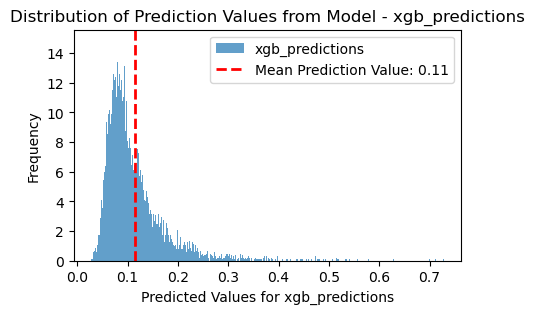

The mean predictive value for the xgb_predictions is: 0.11405916246543996


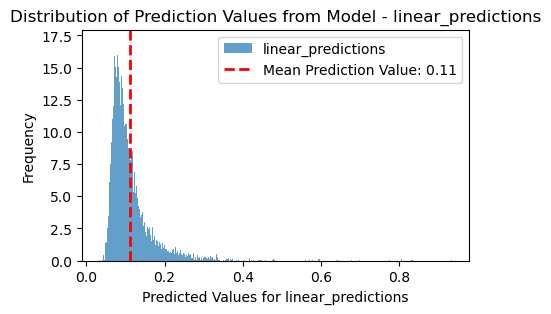

The mean predictive value for the linear_predictions is: 0.11265789014770378


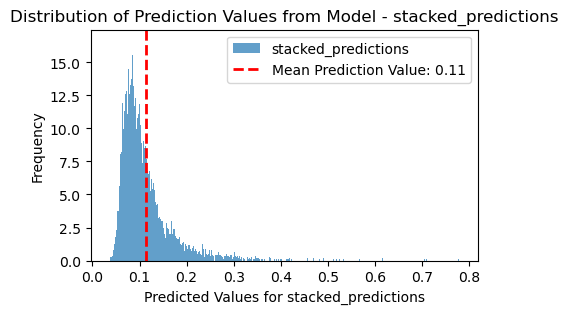

The mean predictive value for the stacked_predictions is: 0.11335852630657187


In [10]:
plot_histograms(diabetes_test, columns_to_plot, hist_figsize)

#### Assessment of raw predictions

Across all of these models, we can. see a similar predictions distribution.

We can see that the predictions demonstrate a relatively similar distribution, having an average prediction around 11%, with a peak below 10%, and a rightward skew towards 100%. Only a few predictions being made above 50%.

Indeed, this makes sense, as only 1 in 10 of our records was an actual readmission, and so it makes sense that these models are hesitant to place heavy weight on any specific prediction. The few predictions made above 50% are likely patients that demonstrate multiple factors identified as being correlated/connected with readmissions. 

Although the model is hesitant to make certain predictions, the ability of these models to rank these records in terms of their relative probability of being a readmission is very useful for our analytic purposes. 

We can identify different probability cutoff levels, and apply these levels to be more/less conservative with our predictions, to meet different operational goals.

#### Statistical v Operational assessment

To assess these results, we will need to determine the context with which we view them.

A common approach to assess a binary prediction problem, would be to look at the ROC AUC value. Indeed, this was the metric specified when optimizing our hyperparameters.

While we will certainly assess our 3 models by this metric, we will also be looking at operational considerations, (predominantly dollars saved and readmissions prevented). 

From this perspective, we will assume that once a patient is predicted as being at risk for readmission, they will be enrolled within a diabetes-management-program. This program will provide the support and tools necessary to prevent a readmission.

In this paradime, it is proportionally more important to prevent a readmission than to waste resources on inappropriatley treating a patient who would not have been readmitted

#### Parameters specified for the operational assessments of our models

In [11]:
cost_of_management_program = 500
sucess_rate_of_intervention = 0.5
cost_of_readmission = 15000

As can be seen from the variables above, we are using the approximate values for our assessment:

There is a per-patient expense of implimenting a diabetes-management-program for one month<br/>
There is a 50% chance that the application of this program will result in a prevented readmission<br/>
Every prevented readmission saves $15,000 (i.e. the cost of a readmission)

Of particular, note, these values are mere aproximations, and are likely to vary across geography and health systems. As such, changes to these parameters may change the implications of our assessment considerably.

However, this provides a realistic baseline, and an understanding of how these models might be applied to create operationally optimized prediction models.

#### Exploring different prediction cutoff thresholds:

We will evaluate our predictions in terms of an optimized value for both the AUC metric, and the per-patient cost savings.

While our model gives us a prediction on the likelihood of a readmission for each patient relative to the patient population, it still remains to us to determine the optimal prediction-cutoff-threshold that should be used to determine when a patient should be considered at-risk for a readmission. If we were to merely use a 50%
cutoff value, then we would only identify a small minority of patients as being at risk for a readmission.

Specifically, we will look for 2 different thresholds for each of our 3 types of model predictions (XGBoost, Linear Learner and Stacked). One of these thresholds should optimize the AUC of our predictions, while the other should look to optimize cost savings.

Additionally, two respective lists of predictions (one indicating that every patient is at risk of readmission, and the other indicating that no patients are at risk), will be assessed as baseline comparisons.

This should result in 8 distinct prediction possibility frontiers to contrast in our final evaluation.

#### The below function will assess our predictions across a range of cutoff values, and will print/save these results so that different cutoff levels meeting different purposes can be identified.

In [12]:
def Threshold_Evaluation(probability_rounding_threshold_values, names_of_levels, evaluation_name):
    
    '''The Threshold_Evaluation() function takes different readmission predictions, based on different likelihood roundoff 
    values, and computes various model performance metrics.
    
    Arguments: 
    --------- 
    probability_rounding_threshold_values: A list of probabilities as calculated from each specified prediction 
        cutoff level
    names_of_levels: A list of probabilities, corresponding to each probability iteration of probability_rounding_threshold_values 
    evaluation_name: specified if the predictions are yielded from an XGBoost, Linear Learner, or Stacked model
    outcome_metric_1: specifies the outcome metric being assessed (petient savings, or AUC)
    outcome_metric_2: if applicable, specifies the outcome metric being assessed (petient savings, or AUC)
    
    
    Returns:
    ---------
    result_df: Returns a dataframe representing the output of a model, enabling cross-model assessment
    '''

    result_list = []

    for i, j in zip(probability_rounding_threshold_values, names_of_levels):
        y_test = diabetes_test['readmitted']
        
        #Calculating various statistical and operational metrics
        acc = accuracy_score(y_test, i)
        roc_auc = roc_auc_score(y_test, i)
        precision, recall, _ = precision_recall_curve(y_test, i)
        pr_auc = auc(recall, precision)       
        cm = confusion_matrix(y_test, i)    
        true_positives = cm[1, 1]
        false_positives = cm[0, 1]
        true_negatives = cm[0, 0]
        false_negatives = cm[1, 0]
        
        recall = true_positives/(true_positives+false_negatives)
        precision = true_positives/(true_positives+false_positives)
        specificity = true_negatives/(true_negatives+false_positives)
        f1_score = (2*true_positives)/(2*true_positives + false_positives + false_negatives)
        
        total_cost_of_implimenting_program = cost_of_management_program*(true_positives+false_positives)
        per_patient_outlay = round(total_cost_of_implimenting_program/len(i), 2)
        readmissions_prevented = round(sucess_rate_of_intervention*true_positives)
        savings_from_readmissions_prevention = round((readmissions_prevented) * (cost_of_readmission), 2)
        per_patient_savings_from_readmissions_prevention = round((savings_from_readmissions_prevention/len(i)), 2)
        net_savings_to_hosptial_system = (savings_from_readmissions_prevention) - (total_cost_of_implimenting_program)
        net_per_patient_savings = round(net_savings_to_hosptial_system/len(i), 2)

        # Add these metrics to a dictionary
        result_dict = {

            'Cutoff_Percentage': j,
            'ROC_AUC': roc_auc,
            'Net_Cost_Savings': net_per_patient_savings,
            'Prevented_Readmissions': readmissions_prevented,
            'Recall': recall,
            'Precision': precision,
            'F1_Score': f1_score,
            'Accuracy': acc,
            'PR AUC': pr_auc,
            'True_Positives': true_positives,
            'False_Positives': false_positives,
            'False_Negatives': false_negatives,
            'Specificity': specificity,
            'Per-Patient Savings': per_patient_savings_from_readmissions_prevention,
            'Up_front_Expense': per_patient_outlay,
            'Type_of_assessment': evaluation_name

        }
        result_list.append(result_dict)

    result_df = pd.DataFrame(result_list)
   
    return result_df

#### This functions creates a range of threshold cutoff values

In [13]:
def generate_thresholds(initial_value, total_range, increment, decimal_rounding_place):

    '''The generate_thresholds() function takes an initial threshold value, a range to be applied both above 
    and below this threshold, and an incriment by which to move above/below this initial value, to the range 
    specified, and lastly number of decimal places of the output to be returned. The function then provides 
    a list of threshold values that correspond to the values/range/incriments specified.
    
    Arguments 
    --------- 
    initial_value: A decimal value to be used as the initial prediction cutoff value.
    total_range: The range above/below the initial value that we wish our cutoff list to extend to.
    increment: The incriment by which the returned list will iterate between the initial, and max/min range
    of cutoff values
    decimal_rounding_place: the number of decimal places in the returned output
    
    Return
    ---------
    Returns a list of decimal values, which will constitute the range of prediction cutoff values we will use to assess 
    our models'''    
 
    #Define an empy list to be populated with thresholds
    thresholds = []

    # Generate values in descending order (above and below the initial value)
    for i in range(int(total_range/increment), 0, -1):
        value_above = round(initial_value + i * increment, decimal_rounding_place)
        value_below = round(initial_value - i * increment, decimal_rounding_place)
        
        #add these cutoff values to our list
        thresholds.extend([value_above, value_below])

    # Include the initial value
    thresholds.append(round(initial_value, decimal_rounding_place))
    thresholds = sorted(thresholds, reverse=True)

    return thresholds

#### This function produces a list of predictions made a different cutoff levels, and a seperate list of percentages that correspond sequentially with the cutoff values of this list for labeling purposes

In [14]:
def create_prediction_cutoff_lists(thresholds, column_name):
    
    '''The create_prediction_cutoff_lists() function takes a list of thresholds (i.e. the output of the above 
    generate_thresholds() function) along with the prediction column from the test dataset being compared. It
    then 
    
    Arguments 
    --------- 
    thresholds: a list of thresholds, typically provided by the generate_thresholds() function
    column_name: The name of the predictions column being used
    
    Return
    ---------
    Returns a list of decimal values, which will constitute the range of prediction cutoff values we will use to assess 
    our models'''  
    
    result_lists = []
    name_list = []
    for threshold in thresholds:
        threshold_str = str(threshold).replace(".", "_")
        variable_name = f"pred_{threshold_str}"
        output_variable_name = f"pred_{threshold_str[2:]}"
        result_list = [1 if i >= threshold else 0 for i in diabetes_test[column_name]]
        globals()[output_variable_name] = result_list
        result_lists.append(result_list)
    
    name_list = [f'{decimal * 100:.2f}%' for decimal in thresholds]
    
    return result_lists, name_list   # Move the return statement outside of the for loop

This will be the specifications for our range of cutoff values -- centered at 0.11, ranging above/below this by 0.05, by incriments of 0.0001, displaying up to 5 decimal spots.

In [15]:
paramater_specifications = [0.11, 0.05, 0.0001, 5]

We will now calculate the predictions made by each of our 3 models across ~1000 different cutoff values respectively (i.e. 6%-16%, in incviments of 0.0001).

Once this has been completed, and the outcome metrics for each of these prediction-possibility-frontiets have been calculated, we will store all of these outcome metrics for each of our 3,000 models, and filter on the dataset to identify the best performers in terms of AUC and cost-savings.

#### XGBoost Cutoff Values

In [16]:
param_xgb_thresholds, param_xgb_threshold_list = create_prediction_cutoff_lists(generate_thresholds(*paramater_specifications),
                                                                                    xgb_predictions)

xgb_data = Threshold_Evaluation(param_xgb_thresholds, param_xgb_threshold_list, "xgb")

We have created a dataset describing ~1,000 different cutoff thresholds for out XGBoost model.

In [17]:
print(xgb_data.shape)
xgb_data.sample(3)

(1001, 16)


,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
105,14.95%,0.602970,215.74,309,0.368735,0.221505,0.276758,0.784925,0.330345,618,2172,1058,0.837206,308.63,92.89,xgb
60,15.40%,0.598453,203.79,290,0.346659,0.225281,0.273090,0.794047,0.322426,581,1998,1095,0.850247,289.65,85.86,xgb
899,7.01%,0.559251,358.67,761,0.908115,0.126234,0.221656,0.288254,0.522301,1522,10535,154,0.210388,760.09,401.42,xgb


In [18]:
max_value_row = xgb_data.loc[xgb_data['Net_Cost_Savings'].idxmax()]
max_value_row_auc = xgb_data.loc[xgb_data['ROC_AUC'].idxmax()]

# Step 2: Display the entire row or specific columns
print("Optimized XGBoost Cost Savings cutoff:",max_value_row.iloc[0])
print("Optimized XGBoost AUC cutoff:",max_value_row_auc.iloc[0])

Optimized XGBoost Cost Savings cutoff: 7.69%
Optimized XGBoost AUC cutoff: 11.09%


#### Linear Learner Cutoff Values

In [19]:
param_lin_thresholds, param_lin_threshold_list = create_prediction_cutoff_lists(generate_thresholds(*paramater_specifications),
                                                                                    linear_predictions)

lin_data = Threshold_Evaluation(param_lin_thresholds, param_lin_threshold_list, "linear")

We have created a dataset describing ~1,000 different cutoff thresholds for out Linear model.

In [20]:
print(lin_data.shape)
lin_data.sample(3)

(1001, 16)


,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
689,9.11%,0.602871,341.52,622,0.742243,0.148060,0.246874,0.494606,0.459534,1244,7158,432,0.463499,621.25,279.73,linear
353,12.47%,0.609183,248.50,376,0.448091,0.196803,0.273489,0.734319,0.353243,751,3065,925,0.770274,375.55,127.05,linear
663,9.37%,0.606651,334.93,598,0.714200,0.151904,0.250523,0.523106,0.449000,1197,6683,479,0.499101,597.28,262.35,linear


In [21]:
max_lin_value_row = lin_data.loc[lin_data['Net_Cost_Savings'].idxmax()]
max_lin_value_row_auc = lin_data.loc[lin_data['ROC_AUC'].idxmax()]

print("Optimized Linear Cost Savings cutoff:",max_lin_value_row.iloc[0])
print("Optimized Linear AUC cutoff:",max_lin_value_row_auc.iloc[0])

Optimized Linear Cost Savings cutoff: 8.17%
Optimized Linear AUC cutoff: 11.01%


#### Stacked Model Cutoff Values

In [22]:
param_stacked_thresholds, param_stacked_threshold_list = create_prediction_cutoff_lists(generate_thresholds(*paramater_specifications),
                                                                                    stacked_predictions)

stacked_data = Threshold_Evaluation(param_stacked_thresholds, param_stacked_threshold_list, "stacked")

We have created a dataset describing ~1,000 different cutoff thresholds for our Stacked model.

In [23]:
print(stacked_data.shape)
stacked_data.sample(3)

(1001, 16)


,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
351,12.49%,0.619098,269.08,406,0.484487,0.198145,0.281261,0.723665,0.370082,812,3286,864,0.753710,405.51,136.44,stacked
828,7.72%,0.573833,360.47,734,0.876492,0.131243,0.228301,0.338727,0.510759,1469,9724,207,0.271174,733.12,372.65,stacked
354,12.46%,0.620101,271.17,409,0.488067,0.198303,0.282020,0.722666,0.371751,818,3307,858,0.752136,408.51,137.34,stacked


In [24]:
max_stacked_value_row = stacked_data.loc[stacked_data['Net_Cost_Savings'].idxmax()]
max_stacked_value_row_auc = stacked_data.loc[stacked_data['ROC_AUC'].idxmax()]

print("Optimized Stacked Savings cutoff:",max_stacked_value_row.iloc[0])
print("Optimized Stacked cutoff:",max_stacked_value_row_auc.iloc[0])

Optimized Stacked Savings cutoff: 8.20%
Optimized Stacked cutoff: 10.76%


## 5. Default Comparisons (i.e. intervening with every, or with none, of the patients)

We will now compile the results from all the different prediction cutoff values, so that we can determine those with the highes AUC and/or lowest cost across models.  

We can also identify any other optimized results of interest (i.e. PR AUC, recall, True positives) depending upon interest.

#### We will also include baseline comparisons (i.e. listing EVERY patient as at risk, or NO patient at risk) to compare how different models compare to baseline approaches that could be taken without machine learning.

In [25]:
no_prediction = [0] * len(diabetes_test)

all_predictions = [1] * len(diabetes_test)

In [26]:
all_prediction_data = Threshold_Evaluation([all_predictions], ['100%'], "all_prediction")

no_prediction_data = Threshold_Evaluation([no_prediction], ['0%'], "no_prediction")

/tmp/ipykernel_18302/3461293827.py:38: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positives/(true_positives+false_positives)


The above error message is expected, since there are 0 values in the denominator for precision and recall. This does not impact our assessment.

#### Aggergating our multiple model results into a single dataframe

We now combine all of our different datasets together so that they may be filtered upon/assessed together.

In [27]:
aggregate_data = pd.concat([xgb_data, lin_data, stacked_data, all_prediction_data, no_prediction_data])

In [28]:
print(aggregate_data.shape)
aggregate_data.sample(3)

(3005, 16)


,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
143,14.57%,0.606263,225.00,324,0.386038,0.218433,0.279000,0.777334,0.336495,647,2315,1029,0.826488,323.61,98.61,xgb
983,6.17%,0.514898,341.89,818,0.976730,0.114708,0.205305,0.156146,0.547018,1637,12634,39,0.053066,817.02,475.13,linear
805,7.95%,0.573986,354.97,720,0.859785,0.131743,0.228476,0.351978,0.503588,1441,9497,235,0.288188,719.14,364.16,linear


## 6. Identifying Optimal Predictions

The below function enables us to identify the optimal model given differing parameters of interest from the above created comprehensive dataset of prediction cutoff values.

In [29]:
def select_best_performer(dataset, model_used, metric):
    
    '''The select_best_performer() identifies the top performing model, in the context of a particular 
    outcome metric, and type of model used to make the predictions
    
    Arguments 
    --------- 
    dataset: the dataset containing the various model results (i.e. aggregate_data)
    model_used: The model type being assessed (i.e. xgb, linear, stacked)
    metric: The metric the model is being assessed by. Presumable ROC_AUC or cost, but any column within the
    dataframe could potentially be used.
    
    Return
    ---------
    Returns a list of decimal values, which will constitute the range of prediction cutoff values we will use to assess 
    our models'''
    
    # identifying the relevant data subset
    mask1 = dataset['Type_of_assessment'] == model_used
    subset_data = dataset[mask1]
    max_score = subset_data[metric].max()
    mask2 = subset_data[metric] == max_score

    result = subset_data[mask2]
    
    return result

#### Below we identify 8 prediction sets for analysis, the best performin models, in terms of AUC and cost savings for each of our 3 respective prediction lists (i.e. 6 different predictions) and then our 2 default states (all and no predictions)

In [30]:
best_xgb_auc = select_best_performer(aggregate_data, xgb, ROC_AUC)
best_linear_auc = select_best_performer(aggregate_data, linear, ROC_AUC)
best_xgb_cost = select_best_performer(aggregate_data, xgb, cost)
best_linear_cost = select_best_performer(aggregate_data, linear, cost)
best_stacked_auc = select_best_performer(aggregate_data, stacked, ROC_AUC)
best_stacked_cost = select_best_performer(aggregate_data, stacked, cost)
all_predictions = aggregate_data[aggregate_data["Type_of_assessment"] == 'all_prediction']
no_predictions = aggregate_data[aggregate_data["Type_of_assessment"] == 'no_prediction']

#### We concatinate all of these results together

In [31]:
best_models = pd.concat([best_xgb_auc, best_linear_auc, best_xgb_cost, best_linear_cost,
                        best_stacked_auc, best_stacked_cost, all_predictions, no_predictions])

#reformat index for interpretability
best_models.index = ["xgb_auc", "linear_auc", "xgb_cost", "linear_cost", "stacked_auc", "stacked_cost", "all_prediction", "no_prediction"]

In [32]:
best_models

,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
xgb_auc,11.09%,0.624733,313.09,503,0.600239,0.176926,0.273295,0.643761,0.410889,1006,4680,670,0.649228,502.40,189.31,xgb
linear_auc,11.01%,0.618328,296.24,476,0.568616,0.177072,0.270048,0.656945,0.396915,953,4429,723,0.668041,475.43,179.18,linear
xgb_cost,7.69%,0.583003,365.99,726,0.865752,0.134514,0.232849,0.363364,0.507624,1451,9336,225,0.300255,725.13,359.14,xgb
linear_cost,8.17%,0.583325,358.24,706,0.841885,0.135413,0.233300,0.382474,0.497472,1411,9009,265,0.324764,705.15,346.92,linear
stacked_auc,10.76%,0.623724,317.02,515,0.614558,0.173752,0.270910,0.630843,0.415663,1030,4898,646,0.632889,514.38,197.36,stacked
stacked_cost,8.20%,0.591826,366.59,708,0.844272,0.138332,0.237715,0.395725,0.499992,1415,8814,261,0.339379,707.15,340.56,stacked
all_prediction,100%,0.500000,337.00,838,1.000000,0.111599,0.200791,0.111599,0.555800,1676,13342,0,0.000000,837.00,500.00,all_prediction
no_prediction,0%,0.500000,0.00,0,0.000000,NaN,0.000000,0.888401,0.555800,0,0,1676,1.000000,0.00,0.00,no_prediction


In [33]:
best_models.columns

Index(['Cutoff_Percentage', 'ROC_AUC', 'Net_Cost_Savings',
       'Prevented_Readmissions', 'Recall', 'Precision', 'F1_Score', 'Accuracy',
       'PR AUC', 'True_Positives', 'False_Positives', 'False_Negatives',
       'Specificity', 'Per-Patient Savings', 'Up_front_Expense',
       'Type_of_assessment'],
      dtype='object')

#### Displaying our best performing AUC and cost-savings values

In [34]:
def optimal_model_barchart(dataset, title, x_label, y_label, metric, decimal_places):
    
    
    '''The optimal_model_barchart() function produces a descending barchart displaying a selected outcome metric 
    across our 8 optimized prediction sets, allowing for an easy visual comparison across predictions.
    
    Arguments 
    --------- 
    dataset: the dataset containing the various model results
    title: title of chart
    x_label: x_label of chart
    y_label: y_label of chart
    metric: outcome metric to be displayed
    decimal places: the number of decimal places to display the outcome metric'''
     
    
    best_models_sorted = dataset.sort_values(by=metric, ascending=False)
    best_models_series = pd.Series(best_models_sorted[metric])

    # Set a wider figure size for better aesthetics
    plt.figure(figsize=(10, 5))

    # Choose a colormap for the color gradient
    cmap = plt.get_cmap('Blues')

    # Create a color gradient based on the metric values
    colors = cmap(best_models_series / best_models_series.max())

    # Create the bar chart with the color gradient
    bars = plt.bar(best_models_sorted.index, best_models_series, color=colors)

    # Add labels to each bar with the numeric value
    for bar, value in zip(bars, best_models_series):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.{decimal_places}f}',
                 ha='center', va='bottom', color='black')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

#### Predictions by AUC

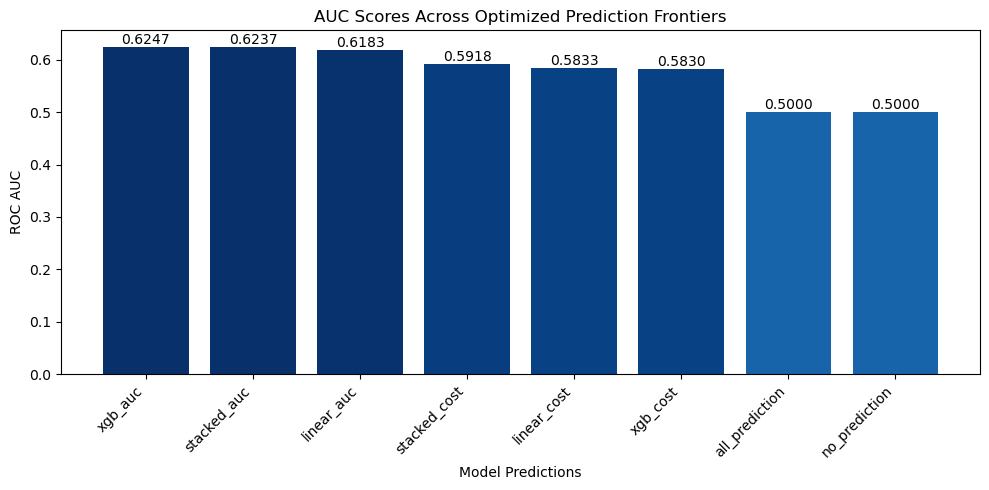

In [35]:
optimal_model_barchart(best_models, "AUC Scores Across Optimized Prediction Frontiers", "Model Predictions", 
                       "ROC AUC", ROC_AUC, 4)

#### Predictions by cost savings

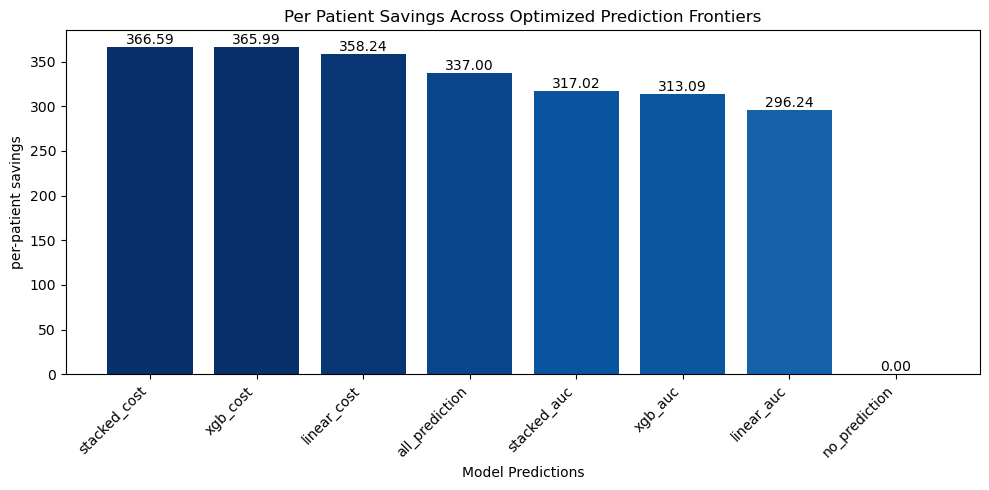

In [36]:
optimal_model_barchart(best_models, "Per Patient Savings Across Optimized Prediction Frontiers", 
                       "Model Predictions", "per-patient savings", cost, 2)

As can be seen in the above, the <b>best AUC is realized through an XGBoost model (.625)</b>, with a stacked model performing closely behind (.623) <br>
Alternately, the <b>highest cost savings can be seen through a stacked model (366.59 dollars)</b>, with a pure XGBoost model performing at (365.99 dollars)

### Considering different outcome metrics

Before determining our rationale for which of these 2 final models to select (i.e. the AUC maximizing or cost minimizing model iterations), <u>let us also considering focusing upon some other outcome metrics to assess as well</u>, namely those most directly tied to readmissions, specifically: <br>
-<b>the number of prevented readmissions</b> <br>
-<b>the Recall</b> <br>
-<b>the PR AUC</b>

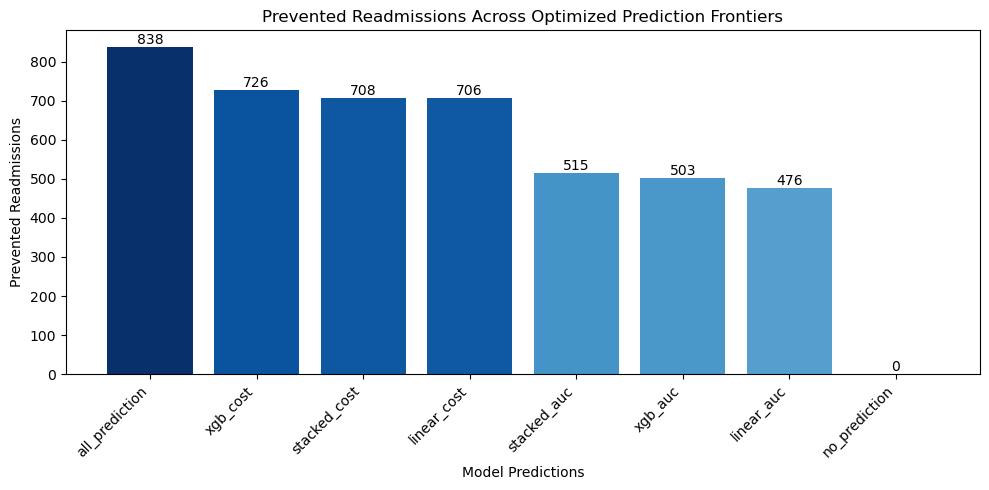

In [38]:
optimal_model_barchart(best_models, "Prevented Readmissions Across Optimized Prediction Frontiers", 
                       "Model Predictions", "Prevented Readmissions", Prevented_Readmissions, 0)

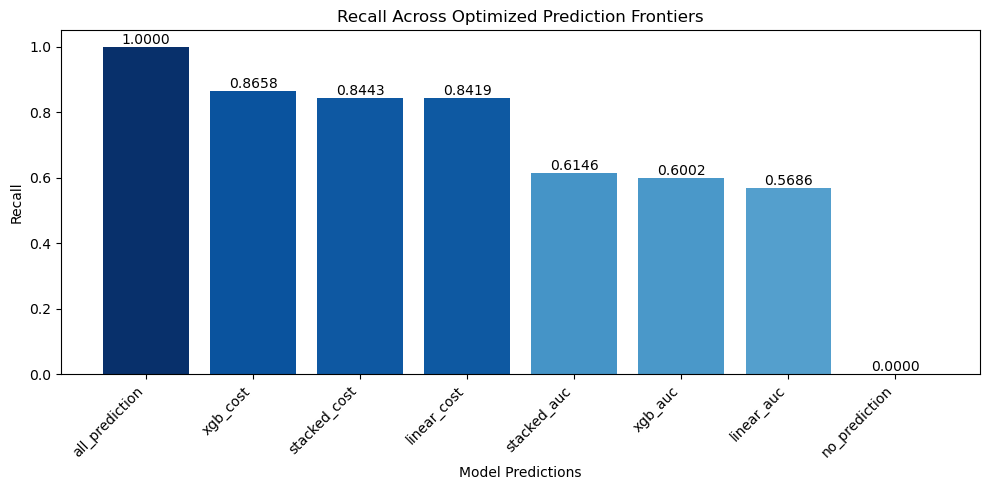

In [39]:
optimal_model_barchart(best_models, "Recall Across Optimized Prediction Frontiers", "Model Predictions", "Recall", 
                       Recall, 4)

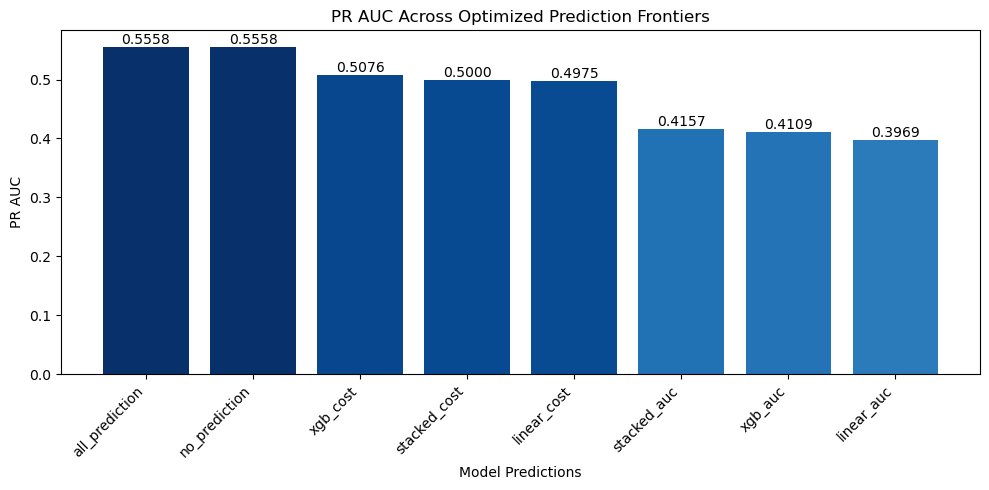

In [40]:
optimal_model_barchart(best_models, "PR AUC Across Optimized Prediction Frontiers", "Model Predictions", "PR AUC",
                       PR_AUC, 4)

#### Discussion of optimizing prevented readmissions/Recall/PR AUC

As can be seen in the above chart that our "all_prediction" default state, (where all patients are considered at risk and therefore enrolled in a diabetes-management-program) provides the best outcomes for all three (prevented readmissions, recall, PR AUC) of these outcome metrics.

Indeed, this makes sense, as if each and every patient recieves an intervention, this will logically reduce the number of readmissions overall. Indeed, with our parameters, this still saves over $300 per patient, as reducing readmissions saves, according to our parameters, enough to cover 30 individual readmission-prevention programs.

However, for the additional ~100 or so prevented readmissions prevented by this approach (relative to our AUC or cost-savings models), the average savings per-patient decreases. This implies that for each prevented readmission, <b>we are employing enough unecessary prevention programs, so that the cost of these programs exceeds the savings from the averted reasmission</b>. This implies that we are seeing a diminishing return on investment.

It must be remembered that saved dollars can be allocated elsewhere to provide additional value (e.g. they could be used to improve the the efficacy of the diabetes-readmission-program, resulting in further reduced readmissions, by prioritizing resources on patients who need it most. It is also almost certain that for many patients, this program would be entirely unecessary and a waste.

It is likely that <b>the involvement of a primary care practitioner could play a valuable role here</b>, in taking the model's predictions, incorporating this with their knowledge of the patient, thereby making a full an informed decision about whether a diabetes-managment-program is right for the patient in question. This clinician could use the deployed version of the model to obtain the patient's predicted risk in real time, and then use this information along with other contextual knowledge to determine whether a diabetes-readmission-program makes sense for the patient.

Also, from a public health perspective, it is worth noting that substantial savings and prevented readmissions can be achieved without fancy machine learning, by simply applying preventative, cost-effecient steps when caring for high-risk patients.

### With this in mind, we will continue to focus on the cost savings model as our "best" model iteration (i.e. the stacked model with an 8.2 percent prediction cutoff threshold).

This model takes into account the relative risk of each patient (unlike the blanket approach) while minimizing costs and still correctly identifying the vast majority (~85%) of True Positives.

Let us assess this model with a confusion matrix.

#### Below is a confusion matrix to better visualize our "best" model (i.e. the stacked cost-optimized model):

In [41]:
def Plot_Confusion_Matrix(y_true, y_pred, classes,
                             normalize=False,
                             title=None, 
                             cmap=None,
                             figsize=(6, 6),
                             xticks=None,
                             yticks=None,
                             show_colorbar=True):  # Add a parameter to control the colorbar

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Remove the colorbar if show_colorbar is set to False
    if not show_colorbar:
        ax.figure.colorbar(im, ax=ax).remove()
    
    # Formatting tick marks
    ax.set(xticks=xticks if xticks else np.arange(cm.shape[1]),
           yticks=yticks if yticks else np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    # Add space between the title and the chart
    plt.subplots_adjust(top=0.8)  # Adjust the top margin as needed
    
    fig.tight_layout()
    return ax


#### Defining additional variables for our confusion matrix

In [42]:
#We recreate our predictions list for the stacked model at the 8.2% cutoff
optimal_cost = [0.082, 0.001, 0.001, 4]
opt_thresholds, opt_thresh_list = create_prediction_cutoff_lists(generate_thresholds(*optimal_cost), stacked_predictions)

class_names = np.array(['Not Readmitted', 'Readmitted'])
y_test = diabetes_test['readmitted']
y_pred_stacked_cost = opt_thresholds[1]

#### Creating a connfusion matrix for our optimized model

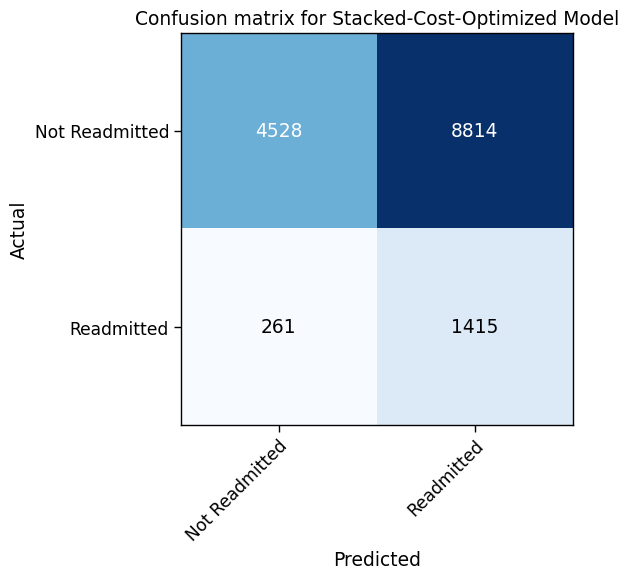

In [43]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = diabetes_test['readmitted']
y_pred = y_pred_stacked_cost

class_names = np.array(['Not Readmitted', 'Readmitted'])

# Plot non-normalized confusion matrix
Plot_Confusion_Matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix for Stacked-Cost-Optimized Model',
                      cmap=plt.cm.Blues)
plt.grid(False)

plt.show()

#### Output metrics for our optimized model

In [44]:
best_models.loc['stacked_cost']

Cutoff_Percentage            8.20%
ROC_AUC                   0.591826
Net_Cost_Savings            366.59
Prevented_Readmissions         708
Recall                    0.844272
Precision                 0.138332
F1_Score                  0.237715
Accuracy                  0.395725
PR AUC                    0.499992
True_Positives                1415
False_Positives               8814
False_Negatives                261
Specificity               0.339379
Per-Patient Savings         707.15
Up_front_Expense            340.56
Type_of_assessment         stacked
Name: stacked_cost, dtype: object

### The above model has been selected as our final model, as it maximizes the savings per-patient, while detecting the vast majority of True Positives.

For additional assessment of these results, please see the accompanying analysis page: https://wbst-bkt.s3.amazonaws.com/index.html